## Model Selection

Import libraries and load the current modeling data for `AmazonReviews`

In [3]:
from nltk.corpus import words, stopwords
from nltk import SnowballStemmer
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from skopt import BayesSearchCV

# latest sklearn issue
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')
        
from skopt.space import Real, Integer, Categorical

from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score


import numpy as np
import pandas as pd
import dill

import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format = 'svg'

stemmer = SnowballStemmer('english')

def english_corpus(doc, tkpat=re.compile('\\b[a-z][a-z]+\\b')):
    return [stemmer.stem(w) for w in tkpat.findall(doc)]

MODELING_PATH = '../data/modeling/'
PATH = '../data/amazon_reviews_us_Toys_v1_00.tsv'

In [4]:
# save progress
def save(obj, obj_name):
    f = MODELING_PATH + obj_name
    dill.dump(obj, open(f, 'wb'))

def load(obj_name):
    f = MODELING_PATH + obj_name
    return dill.load(open(f, 'rb'))

In [27]:
%load_ext autoreload
%autoreload 2

In [5]:
from AmazonReviews import AmazonReviews

ar = AmazonReviews()

In [30]:
ar.load_data(PATH)
ar.calc_trend_score()
ar.create_observations()
ar.create_train_test_split()

Read from pickle...


## Setup

Create inital dictionaries of standard parameters to be utilized in the different algorithms. 

In [6]:
skf = StratifiedKFold(n_splits = 5, random_state=ar.RANDOM_STATE) # 80/20 split

In [7]:
stop_words = load('stop_words.pkl')
count_vectorizer_parameters = {
    'stop_words': stop_words, 
    'tokenizer': lambda x: [stemmer.stem(w) for w in re.compile('\\b[a-z][a-z]+\\b').findall(x)], 
    'min_df': 100,
    'max_df': 0.2,
    'ngram_range': (1,2)
}

In [8]:
lda_parameters = {
    'n_components': 5,
    'learning_decay': 0.6,
    'batch_size': 256,
    'learning_offset': 1024,
    'learning_method': 'online',
    'topic_word_prior': 0.005,
    'n_jobs': -1,
    'random_state': ar.RANDOM_STATE
}

xgb_parameters = {
    'random_state': ar.RANDOM_STATE,
    'n_jobs': -1,
    'objective': 'binary:logistic'
}

bayes_cv_parameters = {
    'n_iter': 10,
    'scoring': 'roc_auc',
    'n_jobs': -1,
    'cv': skf,
    'random_state': ar.RANDOM_STATE,
    'verbose': 2
}

## 5 topic baseline model

Create the document transformation pipeline.

In [65]:
doc_pipeline = Pipeline(
    [
        ('cnt_vector', CountVectorizer(**count_vectorizer_parameters)),
        ('lda', LatentDirichletAllocation(**lda_parameters)),
        ('log_tansform', FunctionTransformer(np.log))
    ]
)

Transform `X_train`.

In [66]:
ar.X_train.head()

43652     this is great for your hair  and it chainges c...
110963    Not worth   bucks!!!!! This toy feels really c...
148853    I saw this same size at Walmart for $ . .  Grr...
193505    There is nothing wrong with the quality of the...
141197    I purchased this boat as a RTR boat it ran awe...
Name: review_body, dtype: object

In [67]:
X_train_transformed = doc_pipeline.fit_transform(ar.X_train)
pd.DataFrame(X_train_transformed).head()

,0,1,2,3,4
0,-1.171857,-1.519457,-2.252676,-3.803085,-1.067233
1,-3.386933,-0.663706,-5.518817,-5.505281,-0.813796
2,-3.552461,-0.675773,-3.555348,-0.904099,-3.536834
3,-0.746880,-1.060022,-2.414319,-6.074681,-2.430635
4,-4.932876,-0.375000,-1.234507,-4.922828,-4.926993


In [68]:
save(X_train_transformed, 'X_train_transformed.pkl')

Create the parameters to perform `BayesSeachCV` over.

In [12]:
xgb_search_params = {
    'max_depth': Integer(2, 6),
    'learning_rate': Real(0, 0.5),
    'n_estimators': Integer(100, 1000),
    'gamma': Real(0, 0.5)
}

Fit the baseline model.

In [9]:
!ls ../data/modeling/ -al

total 110708
drwxrwxr-x 2 ubuntu ubuntu     4096 Nov 12 20:59 .
drwxrwxr-x 3 ubuntu ubuntu     4096 Nov 12 04:06 ..
-rw-rw-r-- 1 ubuntu ubuntu   782046 Nov 12 12:24 baeline_estimator.pkl
-rw-rw-r-- 1 ubuntu ubuntu     4821 Nov 12 12:24 baseline_cv_results.pkl
-rw-r--r-- 1 ubuntu ubuntu  6336163 Nov 12 04:04 baseline_X_train
-rw-rw-r-- 1 ubuntu ubuntu  1357084 Nov 12 12:24 base_SMOTE_search.pkl
-rw-rw-r-- 1 ubuntu ubuntu     1042 Nov 12 20:59 results_df.pkl
-rw-rw-r-- 1 ubuntu ubuntu  1342096 Nov 12 13:15 SMOTE_10t_search.pkl
-rw-rw-r-- 1 ubuntu ubuntu    71926 Nov 12 12:24 stop_words.pkl
-rw-rw-r-- 1 ubuntu ubuntu        0 Nov 12 20:59 test.pkl
-rw-rw-r-- 1 ubuntu ubuntu  4224161 Nov 12 20:59 X_test_SMOTE_10_transformed.pkl
-rw-rw-r-- 1 ubuntu ubuntu 12538323 Nov 12 12:24 X_train_baseline_SMOTE.pkl
-rw-rw-r-- 1 ubuntu ubuntu 31648447 Nov 12 12:24 X_train.pkl
-rw-rw-r-- 1 ubuntu ubuntu 25076483 Nov 12 12:39 X_train_SMOTE_10t.pkl
-rw-rw-r-- 1 ubuntu ubuntu 12672163 Nov 12 12:39 X_train_t

In [10]:
X_train_transformed = load('X_train_transformed.pkl')
ar.y_train = load('y_train.pkl')

In [13]:
xgb = XGBClassifier(**xgb_parameters)

bayes_search = BayesSearchCV(xgb, xgb_search_params, **bayes_cv_parameters)

bayes_search.fit(X_train_transformed, ar.y_train)
save(bayes_search, 'baseline_search.pkl')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   51.4s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   56.0s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.2s remaining:   31.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   57.7s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.1s remaining:   25.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   57.7s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   60.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   60.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   49.7s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   34.8s remaining:   52.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.6s finished


In [14]:
y_pred = bayes_search.best_estimator_.predict_proba(X_train_transformed)[:,1]

ar.log_score(ar.y_train, y_pred, '5_topic')
save(ar.results, 'results_df.pkl')
save(ar.y_scores, 'y_scores.pkl')
ar.results

,AUC,Accuracy,F1,Precision,Recall
5_topic,0.910513,0.989514,0.014243,1.0,0.007173


Pretty high AUC, but the confusion matrix metrics are most likely skewed with the default cutoff of 50%.

## 5-topic SMOTE model

Let's now try up-sampling to see if this can improve the classification.

In [15]:
smote_pipeline = imbPipeline(
    [
        ('sm', SMOTE(random_state=ar.RANDOM_STATE, n_jobs=-1)),
        ('xgb', XGBClassifier(**xgb_parameters))
    ],
    memory = '../data/transform_memory/'
)

xgb_smote_search_params = {
    'xgb__max_depth': Integer(2, 6),
    'xgb__learning_rate': Real(0, 0.5),
    'xgb__n_estimators': Integer(100, 1000),
    'xgb__gamma': Real(0, 0.5)
}


In [16]:
bayes_search = BayesSearchCV(smote_pipeline, xgb_smote_search_params, **bayes_cv_parameters)

bayes_search.fit(X_train_transformed, ar.y_train)
save(bayes_search, 'SMOTE_5t_search.pkl')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.2s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   37.0s remaining:   55.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


In [17]:
y_pred = bayes_search.best_estimator_.predict_proba(X_train_transformed)[:,1]

In [18]:
ar.log_score(ar.y_train, y_pred, 'SMOTE_5t')
ar.results

,AUC,Accuracy,F1,Precision,Recall
5_topic,0.910513,0.989514,0.014243,1.00000,0.007173
SMOTE_5t,0.797784,0.739470,0.054180,0.02817,0.706515


In [19]:
save(ar.results, 'results_df.pkl')
save(ar.y_scores, 'y_scores.pkl')

Applying SMOTE decreased the AUC from **0.91** to **0.79**.

5_topic
SMOTE_5t


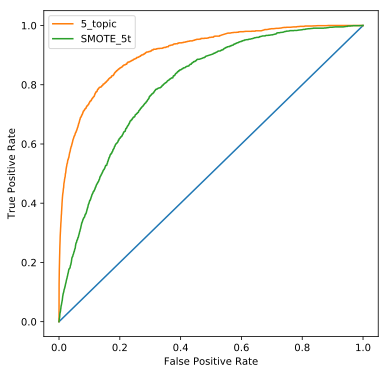

In [20]:
ar.y_train = load('y_train.pkl')
ar.plot_roc_curve();

In [21]:
pd.DataFrame(bayes_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
0,122.933320,1.193159,0.655716,0.205052,0.363863,6,384,"{'xgb__gamma': 0.20505197942665693, 'xgb__lear...",1,0.675278,0.646144,0.672189,0.627126,0.657841,4.880232,0.152969,0.017706
1,139.996067,1.294779,0.678534,0.418694,0.441658,3,956,"{'xgb__gamma': 0.4186941777766422, 'xgb__learn...",1,0.673510,0.686828,0.697366,0.652392,0.682576,7.822521,0.052503,0.015155
2,46.485036,0.398324,0.712347,0.222416,0.459361,2,490,"{'xgb__gamma': 0.22241625615057592, 'xgb__lear...",1,0.696173,0.725059,0.732692,0.695067,0.712742,3.511774,0.005068,0.015072
3,161.188852,1.491554,0.702998,0.406198,0.085936,4,822,"{'xgb__gamma': 0.4061979941786817, 'xgb__learn...",1,0.691615,0.711735,0.718971,0.685216,0.707451,8.484046,0.042646,0.012626
4,144.588635,1.318725,0.683669,0.399777,0.219015,4,744,"{'xgb__gamma': 0.39977672080358656, 'xgb__lear...",1,0.685115,0.683236,0.701308,0.663130,0.685557,5.180795,0.018610,0.012156
5,39.317711,0.319147,0.702457,0.367014,0.469685,3,270,"{'xgb__gamma': 0.3670140089927842, 'xgb__learn...",1,0.679684,0.719155,0.720929,0.681620,0.710896,2.442707,0.046972,0.018133
6,127.560940,1.190942,0.685211,0.308540,0.387682,3,887,"{'xgb__gamma': 0.30853967925115816, 'xgb__lear...",1,0.681127,0.689976,0.706768,0.661211,0.686972,6.815955,0.008978,0.014719
7,169.848792,1.618786,0.662848,0.271702,0.460005,4,854,"{'xgb__gamma': 0.2717015338451563, 'xgb__learn...",1,0.668710,0.659701,0.681210,0.634843,0.669777,7.675517,0.242879,0.015580
8,119.182855,1.157184,0.665885,0.477739,0.350311,5,474,"{'xgb__gamma': 0.47773899315496415, 'xgb__lear...",1,0.666536,0.666124,0.685190,0.638226,0.673346,7.582207,0.032357,0.015452
9,81.965714,0.780865,0.666905,0.001815,0.408915,5,329,"{'xgb__gamma': 0.0018151536273716133, 'xgb__le...",1,0.671315,0.669132,0.678692,0.646385,0.669002,4.979502,0.008296,0.010852


## 10-topic Model

Let's now see the impact of increasing the LDA topics from 5 to 10, but not applying SMOTE.

In [22]:
ar.X_train = load('X_train.pkl')
ar.y_train = load('y_train.pkl')

In [23]:
lda_parameters['n_components'] = 10
# count_vectorizer_parameters['stop_words'] = load('stop_words.pkl')

doc_pipeline = Pipeline(
    [
        ('cnt_vector', CountVectorizer(**count_vectorizer_parameters)),
        ('lda', LatentDirichletAllocation(**lda_parameters)),
        ('log_tansform', FunctionTransformer(np.log))
    ]
)

In [24]:
X_train_transformed = doc_pipeline.fit_transform(ar.X_train)
save(X_train_transformed, 'X_train_transformed_10_topics.pkl')

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abbiat', 'abov', 'ag', 'ahogi', 'alguna', 'alguno', 'ame', 'anch', 'ani', 'ant', 'anum', 'aquel', 'ata', 'atar', 'aurion', 'auron', 'avai', 'avess', 'avest', 'avet', 'avev', 'avion', 'avon', 'avrebb', 'avrest', 'avret', 'ayon', 'baiknya', 'becaus', 'befor', 'begg', 'benn', 'beraw', 'berkali', 'catr', 'dag', 'dasselb', 'deir', 'depoi', 'dera', 'derselb', 'desd', 'despr', 'dett', 'dieselb', 'diss', 'diy', 'doe', 'dond', 'durant', 'dure', 'ebb', 'egi', 'egyr', 'ell', 'ello', 'emm', 'entr', 'erai', 'erav', 'ere', 'err', 'ess', 'estabai', 'estamo', 'estaremo', 'estejamo', 'estemo', 'estev', 'estiv', 'estivemo', 'estivermo', 'estivess', 'estuv', 'estuvierai', 'estuvies', 'estuviesei', 'estuvimo', 'estuvist', 'estuvistei', 'etwa', 'eur', 'euss', 'eussion', 'facciat', 'faces

In [25]:
bayes_search = BayesSearchCV(xgb, xgb_search_params, **bayes_cv_parameters)
bayes_search.fit(X_train_transformed, ar.y_train)
save(bayes_search, '10t_search.pkl')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   33.7s remaining:   50.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   27.4s remaining:   41.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   56.3s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [26]:
y_probs = bayes_search.best_estimator_.predict_proba(X_train_transformed)[:,1]

In [30]:
ar.log_score(ar.y_train, y_probs, '10_topic')

In [33]:
ar.results

,AUC,Accuracy,F1,Precision,Recall
5_topic,0.910513,0.989514,0.014243,1.00000,0.007173
SMOTE_5t,0.797784,0.739470,0.054180,0.02817,0.706515
10_topic,0.924817,0.989545,0.020118,1.00000,0.010161


5_topic
SMOTE_5t
SMOTE_10t


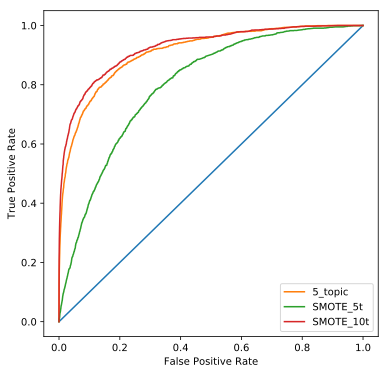

In [29]:
ar.plot_roc_curve()

In [35]:
np.abs(0.910513 - 0.924817)/ 0.910513

0.015709825120563882

The AUC improved further with the utilizing 10 topics from **0.91** to **0.92**, which is about 1.5% increase.

In [45]:
!ls ../data/modeling/ -lat

total 112392
-rw-rw-r-- 1 ubuntu ubuntu  1901262 Nov 12 22:32 y_scores.pkl
-rw-rw-r-- 1 ubuntu ubuntu     1126 Nov 12 22:32 results_df.pkl
-rw-rw-r-- 1 ubuntu ubuntu   802667 Nov 12 22:11 10t_search.pkl
drwxrwxr-x 2 ubuntu ubuntu     4096 Nov 12 22:11 .
-rw-rw-r-- 1 ubuntu ubuntu 12672269 Nov 12 21:55 X_train_transformed_10_topics.pkl
-rw-rw-r-- 1 ubuntu ubuntu   315706 Nov 12 21:45 SMOTE_5t_search.pkl
drwxrwxr-x 4 ubuntu ubuntu     4096 Nov 12 21:24 ..
-rw-rw-r-- 1 ubuntu ubuntu   809475 Nov 12 21:12 baseline_search.pkl
-rw-rw-r-- 1 ubuntu ubuntu        0 Nov 12 20:59 test.pkl
-rw-rw-r-- 1 ubuntu ubuntu  6336269 Nov 12 20:59 X_train_transformed.pkl
-rw-rw-r-- 1 ubuntu ubuntu  4224161 Nov 12 20:59 X_test_SMOTE_10_transformed.pkl
-rw-rw-r-- 1 ubuntu ubuntu  1342096 Nov 12 13:15 SMOTE_10t_search.pkl
-rw-rw-r-- 1 ubuntu ubuntu  2507793 Nov 12 12:39 y_train_SMOTE_10t.pkl
-rw-rw-r-- 1 ubuntu ubuntu 25076483 Nov 12 12:39 X_train_SMOTE_10t.pkl
-rw-rw-r-- 1 ubuntu ubuntu  2507793 Nov 12 12:24 

In [38]:
b_search_5_topic = load('baseline_search.pkl')
b_search_smote_5_topic = load('SMOTE_5t_search.pkl')
b_search_10_topic = load('10t_search.pkl')

In [40]:
print(b_search_5_topic.best_score_, b_search_smote_5_topic.best_score_, b_search_10_topic.best_score_)

0.7112579818344774 0.71234656407633 0.7107978637308618


In [41]:
ar.results

,AUC,Accuracy,F1,Precision,Recall
5_topic,0.910513,0.989514,0.014243,1.00000,0.007173
SMOTE_5t,0.797784,0.739470,0.054180,0.02817,0.706515
10_topic,0.924817,0.989545,0.020118,1.00000,0.010161


## Next Model
* Could look at the first week of reviews, essentially adding data to the model. 

### Other ToDos
* Baseline non-ML model
* Cost function for FPR and FNR tradeoff
* See if I am overfitting and reduce bias

In [42]:
save(ar.results, 'results_df.pkl')
save(ar.y_scores, 'y_scores.pkl')

In [8]:
bayes_search = load('SMOTE_10t_search.pkl')

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [9]:
bayes_search.best_params_

{'gamma': 0.20505197942665693,
 'learning_rate': 0.36386287158866254,
 'max_depth': 6,
 'n_estimators': 384}

In [16]:
doc_pipeline.fit(ar.X_train)

Pipeline(memory=None,
     steps=[('cnt_vector', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.2, max_features=None, min_df=100,
        ngram_range=(1, 2), preprocessor=None,
        stop_words={'n...rgs=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=True))])

In [18]:
X_test_transformed = doc_pipeline.transform(ar.X_test)

In [19]:
y_test_probs = bayes_search.best_estimator_.predict_proba(X_test_transformed)[:,1]

In [32]:
ar.results = load('results_df.pkl')
ar.y_scores = load('y_scores.pkl')
ar.log_score(ar.y_test, y_test_probs, 'SMOTE_10t_TEST')

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [33]:
ar.results

,AUC,Accuracy,F1,Precision,Recall
baseline,0.912250,0.989508,0.013064,1.000000,0.006575
base_SMOTE,0.954279,0.904577,0.164502,0.090632,0.889420
SMOTE_10t,0.974237,0.994369,0.670849,0.876567,0.543335
SMOTE_10t_TEST,0.631593,0.976818,0.014493,0.013158,0.016129


ValueError: Found input variables with inconsistent numbers of samples: [158400, 52800]

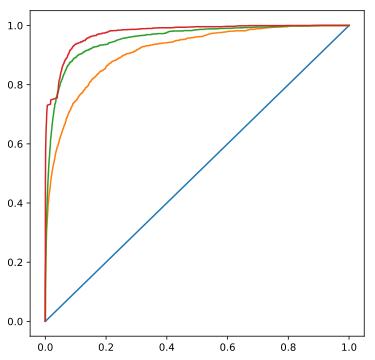

In [34]:
ar.plot_roc_curve() # update to use y_test if TEST

In [35]:
save(ar.results, 'results_df.pkl')
save(ar.y_scores, 'y_scores.pkl')
save(X_test_transformed, 'X_test_SMOTE_10_transformed.pkl')

In [36]:
bayes_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.20505197942665693,
       learning_rate=0.36386287158866254, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, n_estimators=384, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [ ]:
XGBClassifier()

In [37]:
lda_parameters['n_components'] = 5
# count_vectorizer_parameters['stop_words'] = load('stop_words.pkl')

doc_pipeline = Pipeline(
    [
        ('cnt_vector', CountVectorizer(**count_vectorizer_parameters)),
        ('lda', LatentDirichletAllocation(**lda_parameters)),
        ('log_tansform', FunctionTransformer(np.log))
    ]
)

In [38]:
doc_pipeline.fit(ar.X_train)
X_test_trans_5t = doc_pipeline.transform(ar.X_test)

In [39]:
bayes_search_5t = load('base_SMOTE_search.pkl')

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [40]:
y_test_probs_5t = bayes_search_5t.best_estimator_.predict_proba(X_test_trans_5t)[:,1]

In [41]:
ar.log_score(ar.y_test, y_test_probs_5t, 'SMOTE_5t_TEST')
ar.results

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,AUC,Accuracy,F1,Precision,Recall
baseline,0.912250,0.989508,0.013064,1.000000,0.006575
base_SMOTE,0.954279,0.904577,0.164502,0.090632,0.889420
SMOTE_10t,0.974237,0.994369,0.670849,0.876567,0.543335
SMOTE_10t_TEST,0.631593,0.976818,0.014493,0.013158,0.016129
SMOTE_5t_TEST,0.648842,0.867462,0.042943,0.023245,0.281362


In [44]:
pd.DataFrame(bayes_search.cv_results_).sort_values('mean_test_score', ascending=False)

## I think the issue is that I am doing SMOTE on the train data set prior to CV which pollutes the validation
## data set during the k-fold tuning. Why? I should split, SMOTE train, score against validation 
## which is not SMOTE!!!

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,params
0,0.992704,0.999067,0.999094,0.999062,0.998949,0.997775,0.002536,1,206.543422,3.003091,2.228214,0.237132,0.205052,0.363863,6,384,"{'gamma': 0.20505197942665693, 'learning_rate'..."
7,0.991175,0.998902,0.998921,0.998944,0.998767,0.997342,0.003084,1,278.893461,8.148077,3.041350,0.518867,0.271702,0.460005,4,854,"{'gamma': 0.2717015338451563, 'learning_rate':..."
8,0.991381,0.998636,0.998719,0.998791,0.998609,0.997227,0.002924,1,201.226972,5.106945,2.166476,0.014847,0.477739,0.350311,5,474,"{'gamma': 0.47773899315496415, 'learning_rate'..."
9,0.990189,0.998298,0.998343,0.998396,0.998165,0.996678,0.003245,1,137.419901,8.188450,1.475943,0.103394,0.001815,0.408915,5,329,"{'gamma': 0.0018151536273716133, 'learning_rat..."
1,0.987766,0.997602,0.997710,0.997670,0.997492,0.995648,0.003942,1,227.129983,7.795610,2.525772,0.260873,0.418694,0.441658,3,956,"{'gamma': 0.4186941777766422, 'learning_rate':..."
4,0.988313,0.997275,0.997183,0.997373,0.996955,0.995420,0.003556,1,240.831171,7.837924,2.694498,0.300497,0.399777,0.219015,4,744,"{'gamma': 0.39977672080358656, 'learning_rate'..."
6,0.986987,0.996775,0.996928,0.996975,0.996640,0.994861,0.003939,1,209.137936,5.201123,2.429658,0.253271,0.308540,0.387682,3,887,"{'gamma': 0.30853967925115816, 'learning_rate'..."
3,0.980779,0.990134,0.990268,0.990638,0.990171,0.988398,0.003814,1,262.959290,7.934804,2.835688,0.155756,0.406198,0.085936,4,822,"{'gamma': 0.4061979941786817, 'learning_rate':..."
5,0.977190,0.988487,0.989006,0.988865,0.986762,0.986062,0.004508,1,62.519576,4.047477,0.566572,0.022668,0.367014,0.469685,3,270,"{'gamma': 0.3670140089927842, 'learning_rate':..."
2,0.971715,0.982829,0.982445,0.983236,0.982511,0.980547,0.004425,1,76.479028,3.192351,0.739930,0.016173,0.222416,0.459361,2,490,"{'gamma': 0.22241625615057592, 'learning_rate'..."


In [45]:
bayes_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.20505197942665693,
       learning_rate=0.36386287158866254, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, n_estimators=384, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)